# Importing libraries

In [1]:
import requests
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import APIs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
%matplotlib inline
%config InlineBackend.figure_format='retina'
fred_key = APIs.fred_api

Defining function to get fred data: fredData

In [2]:
def fredData(request_dict, start_date, end_date, api_key, freq = 'Q'):
    """ download some data from fred """
    import pandas as pd
    import numpy as np
    import requests
    base = 'https://api.stlouisfed.org/fred/series/observations?series_id='
    dates = '&observation_start={}&observation_end={}'.format(start_date, end_date)
    api_key = '&api_key={}'.format(api_key)
    ftype = '&file_type=json'
    
    dataFrame = pd.DataFrame()
    for code, name in request_dict.items():
        url = '{}{}{}{}{}'.format(base, code, dates, api_key, ftype)
        r = requests.get(url).json()['observations']
        dataFrame[name[0]] = [i['value'] for i in r]

    dataFrame = dataFrame.replace('.', np.nan)    
    dataFrame = dataFrame.astype(float)

    sectors = pd.MultiIndex.from_tuples(list(zip([i[1] for i in request_dict.values()],[i[0] for i in request_dict.values()])))
    dataFrame.columns = sectors

    dates = pd.date_range(start_date, periods=dataFrame.shape[0], freq=freq)
    dataFrame.index = dates
    return dataFrame

"""
# usage 
df = fredData(request_dict=q_dict, start_date=start_date, end_date=end_date, api_key=fred_key)
df
"""

'\n# usage \ndf = fredData(request_dict=q_dict, start_date=start_date, end_date=end_date, api_key=fred_key)\ndf\n'

In [3]:
recessions = pd.read_html('https://www.nber.org/cycles/cyclesmain.html')

peak = recessions[0][0][4]
peak = peak.replace('(I)', '/')
peak = peak.replace('(II)', '/')
peak = peak.replace('(III)', '/')
peak = peak.replace('(IV)', '/')
peak = peak.split('/ ')
peak[-1] = peak[-1].replace(" /", "")
peak = [datetime.strptime(i, '%B %Y') for i in peak]
peak = peak[-8:]

trough = recessions[0][1][4]
trough = trough.replace('(I)', '/')
trough = trough.replace('(II)', '/')
trough = trough.replace('(III)', '/')
trough = trough.replace('(IV)', '/')
trough = trough.replace('March 1991/  November 2001', 'March 1991 / November 2001', )
trough = trough.split(' / ')
trough[-1] = trough[-1].replace(" /", "")
trough = [datetime.strptime(i, '%B %Y') for i in trough[1:]]
trough = trough[-8:]

crisis = pd.DataFrame({'peak': peak, 'trough': trough})

# Quarterly data

In [4]:
q_dict = {
    'MSPUS' : ['Median Sales Price', 'Houses Sold', 'United States'],
    'USSTHPI' : ['All-Transactions', 'House Price Index', 'United States', '1980Q1 = 100'],
    'MDSP' : ['Mortgage Debt Service Payments as a Percent of Disposable Personal Income', 'Mortgage'],
    'HHMSDODNS' : ['Liability, Level', 'Mortgage', 'Households and Nonprofit Organizations'],
    'CCDIHBQ156N' : ['CredAbility Consumer Distress Index', 'Household', 'Household Budget (DISCONTINUED)'],
}

quarterly = fredData(request_dict=q_dict, start_date='1980-01-01', end_date='2010-12-01', api_key=fred_key)

In [5]:
quarterly.head()

Houses Sold House Price Index  \
           Median Sales Price  All-Transactions   
1980-03-31            63700.0            100.00   
1980-06-30            64000.0            101.55   
1980-09-30            64900.0            104.48   
1980-12-31            66400.0            104.75   
1981-03-31            66800.0            105.32   

                                                                            Mortgage  \
           Mortgage Debt Service Payments as a Percent of Disposable Personal Income   
1980-03-31                                           4.375714                          
1980-06-30                                           4.484928                          
1980-09-30                                           4.493386                          
1980-12-31                                           4.512131                          
1981-03-31                                           4.596082                          

                                                      Household  
           Liability, Level CredAbility Consumer Distress Index  
1980-03-31          860.063                           83.422332  
1980-06-30          875.720                           80.737954  
1980-09-30          900.209                           85.124147  
1980-12-31          926.526                           86.067316  
1981-03-31          944.614                           84.385455

# Monthly

In [6]:
m_dict = {
    'CSUSHPINSA' : ['Case-Shiller U.S.', 'National Home Price Index', 'S&P'],
    'MORTG' : ['30-Year Mortgage Rate', 'Conventional Mortgage Rate', 'DISCONTINUED'],
}

monthly = fredData(request_dict=m_dict, start_date='1987-01-01', end_date='2015-12-01', api_key=fred_key, freq='M')

In [7]:
monthly['Conventional Mortgage Rate','30-Year Mortgage Rate'] = monthly['Conventional Mortgage Rate','30-Year Mortgage Rate'].apply(lambda x:x/100)
monthly['National Home Price Index','Case-Shiller U.S.'] = monthly['National Home Price Index','Case-Shiller U.S.'].apply(lambda x:x/100 - 1)
monthly.head()

,National Home Price Index,Conventional Mortgage Rate
,Case-Shiller U.S.,30-Year Mortgage Rate
1987-01-31,-0.36247,0.0920
1987-02-28,-0.35847,0.0908
1987-03-31,-0.35510,0.0904
1987-04-30,-0.35005,0.0983
1987-05-31,-0.34430,0.1060


## Own interest rate

Own interest rate based on Teixeira (2015, 53):
    
$$
r_{pi} = \frac{1+i_{\text{mortgage}}}{1+\pi_{\text{House}}} -1
$$

In [8]:
imortg = [i + 1 for i in monthly['Conventional Mortgage Rate']['30-Year Mortgage Rate']]
pihouse = [i + 1 for i in monthly['National Home Price Index']['Case-Shiller U.S.']]
rip = [imortg[i]/pihouse[i] -1 for i in range(len(pihouse))]

In [9]:
month_self_dict = {
    'Own interest rate' : rip
}
month_self = pd.DataFrame(month_self_dict)
month_self.index = monthly.index
sectors = pd.MultiIndex.from_tuples(list(zip(['Self Elaboration' for i in month_self_dict.keys()],[i for i in month_self_dict.keys()])))
month_self.columns = sectors

In [10]:
month_self.head()

,Self Elaboration
,Own interest rate
1987-01-31,0.712861
1987-02-28,0.700310
1987-03-31,0.690805
1987-04-30,0.689822
1987-05-31,0.686747


In [11]:
dfmonth = pd.concat([monthly, month_self], axis=1)
dfmonth.head()

,National Home Price Index,Conventional Mortgage Rate,Self Elaboration
,Case-Shiller U.S.,30-Year Mortgage Rate,Own interest rate
1987-01-31,-0.36247,0.0920,0.712861
1987-02-28,-0.35847,0.0908,0.700310
1987-03-31,-0.35510,0.0904,0.690805
1987-04-30,-0.35005,0.0983,0.689822
1987-05-31,-0.34430,0.1060,0.686747


# Weekly

In [12]:
w_dict = {
    'MORTGAGE30US' : ['30-Year Fixed Rate', 'Mortgage Average in the United States']
}

weekly = fredData(request_dict=w_dict, start_date='1985-01-01', end_date='2015-01-01', api_key=fred_key, freq='W')

In [13]:
weekly['Mortgage Average in the United States']['30-Year Fixed Rate'] = weekly['Mortgage Average in the United States']['30-Year Fixed Rate'].map(lambda x: x/100)
weekly.head()

,Mortgage Average in the United States
,30-Year Fixed Rate
1985-01-06,0.1310
1985-01-13,0.1312
1985-01-20,0.1312
1985-01-27,0.1296
1985-02-03,0.1293


# Plots

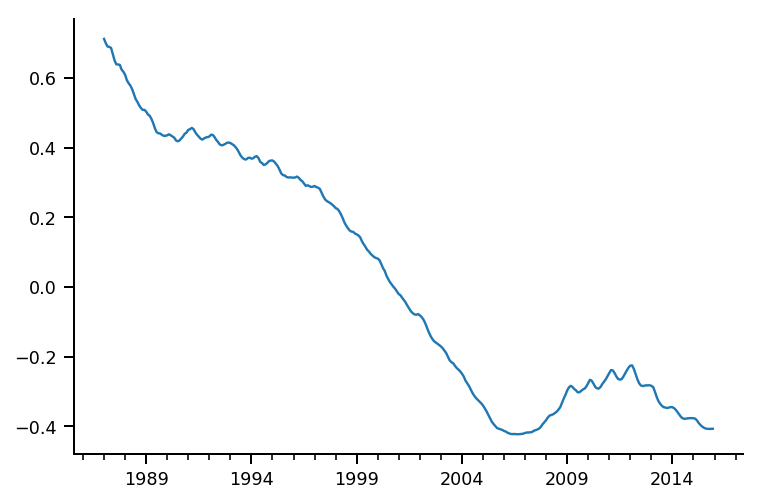

In [14]:
dfmonth['Self Elaboration']['Own interest rate'].plot()
sns.despine()
plt.show()

In [15]:
start = datetime(1987, 1, 1)
end = datetime(2015, 12, 1)

Ihudf = web.DataReader(['HNOREMQ027S', 'PRFI','DPI', 'TCU'], 'fred', start, end, access_key=fred_key)
Ihudf.columns = [
    'real estate at market value',
    'Private Residential Fixed Investment',
    'Disposable Personal Income (DPI)',
    'Capacity utilizarion'
]

Ihudf = Ihudf.resample('Q').mean()

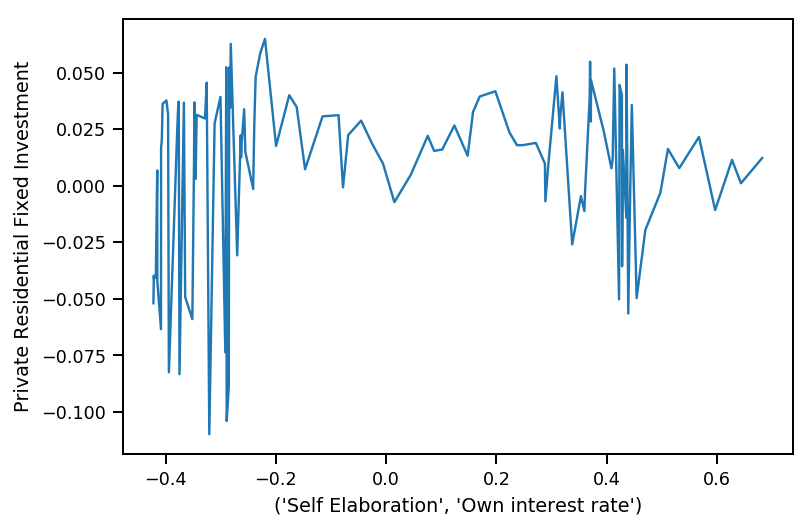

In [16]:
sns.lineplot(x = dfmonth['Self Elaboration','Own interest rate'].resample('Q').mean(), y = Ihudf['Private Residential Fixed Investment'].pct_change())